In [3]:
from typing import List
import sys
sys.path.append('C:/Users/HP/Desktop/Cours/Projet IA/neuroforest-master')
import numpy as np
import pandas as pd

from IPython import display
from PIL import Image, ImageDraw, ImageFont
from scipy.spatial import cKDTree
from scipy.stats import spearmanr

from main import dataloader, to_vect, Coordinates, calculate_asrs, classify_asrs
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2022\trajectories_processed
Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2024\trajectories_processed


In [4]:
sample = next(iter(dataloader))
session = sample["patchy"]
if session is None:
    print("No session")
    sys.exit(1)
ZOOM_FACTOR = 1.5


def transform(coords: List[Coordinates], offset: np.ndarray, factor: float) -> np.ndarray:
    return (to_vect(coords) + offset) * factor


mushrooms_coords = transform(session.mushroom_coords, np.array([200, 0, 200]), ZOOM_FACTOR)
mushrooms_coords = mushrooms_coords[:, [0, 2]]
player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
player_coords = player_coords[:, [0, 2]]

def compute_reach_hull(coords: np.ndarray, d_reach : int = 5) -> np.ndarray:
    # Create a surface around the trajectory with the distance d_reach
    expanded_coords = []
    for coord in coords:
        for dx in [-d_reach, d_reach]:
            for dz in [-d_reach, d_reach]:
                expanded_coords.append([coord[0] + dx, coord[1] + dz])

    reach_hull = np.array(expanded_coords)
    return reach_hull


max_coord_x = int(mushrooms_coords[:, 0].max())
max_coord_z = int(mushrooms_coords[:, 1].max())

  0%|          | 0/39 [00:00<?, ?it/s]

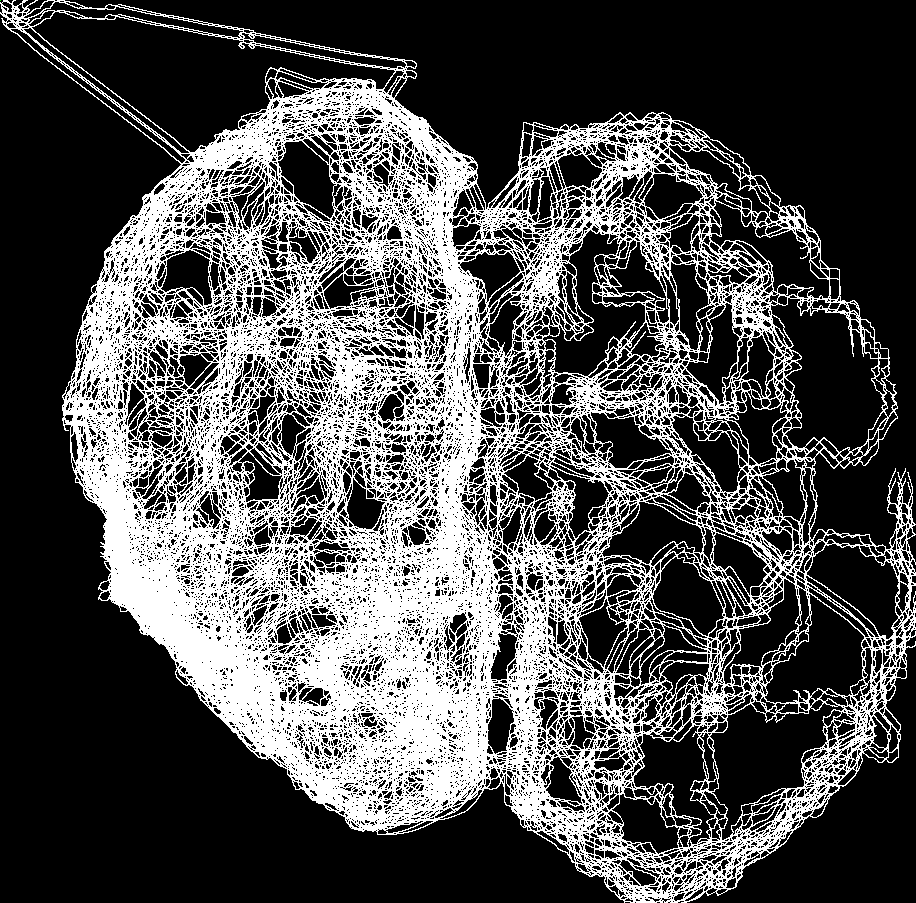

Number of reach hulls over point [250 250] : 7


In [5]:
def count_reach_hulls_over_point(point: Coordinates, d_reach: int) -> int:
    count = 0
    with Image.new(mode="RGB", size=(max_coord_x, max_coord_z)) as im:
        draw = ImageDraw.Draw(im)
        draw.point(point, fill=(0, 255, 0))
        for sample in tqdm(dataloader):
            session = sample["patchy"]
            if session is None:
                continue
            player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
            player_coords = player_coords[:, [0, 2]]
            reach_hull = compute_reach_hull(player_coords, d_reach)
            if any(np.allclose(point, p, atol=d_reach) for p in reach_hull):
                count += 1
            # draw.line([tuple(p) for p in player_coords.astype(int)], fill=(255, 0, 0), width=5)
            draw.point([tuple(p) for p in reach_hull.astype(int)])
        display.display(im)
    return count

# Example usage:
point = np.array([250, 250])
d_reach = 5
print(f"Number of reach hulls over point {point} : {count_reach_hulls_over_point(point, d_reach)}")


  0%|          | 0/39 [00:00<?, ?it/s]

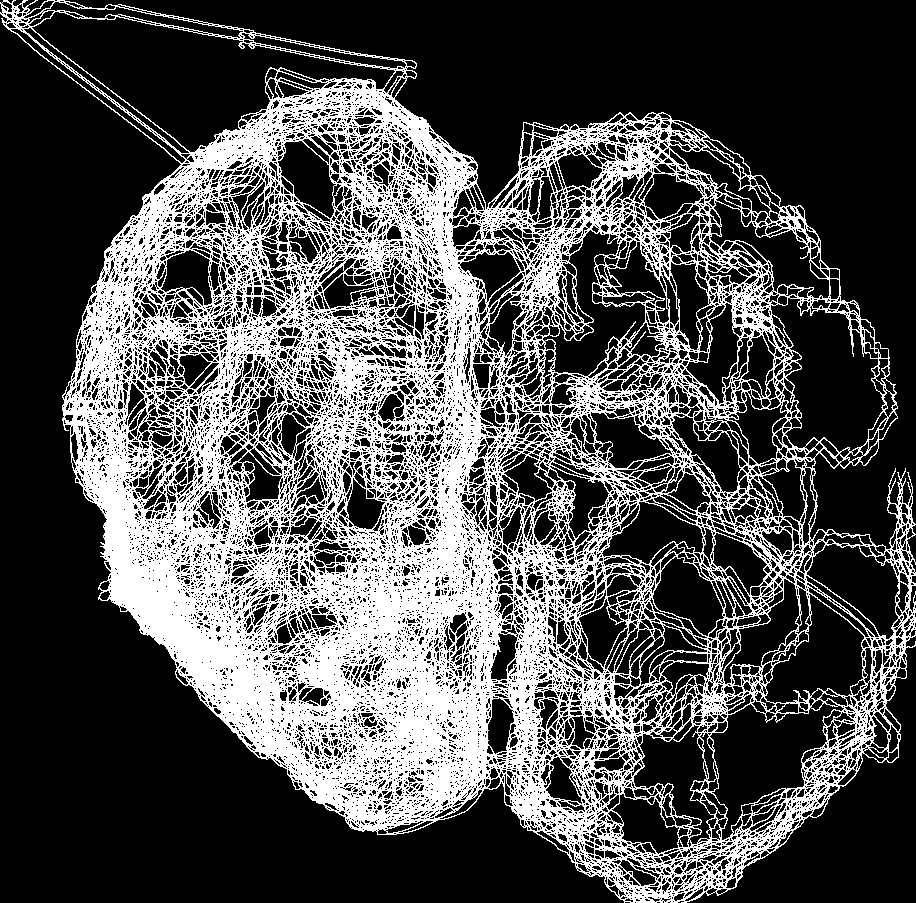

In [3]:
def draw_cross(draw: ImageDraw.Draw, coord: tuple[int, int], time: int):
    offset = 10
    topleft = (coord[0] - offset, coord[1] - offset)
    topright = (coord[0] + offset, coord[1] - offset)
    bottomleft = (coord[0] - offset, coord[1] + offset)
    bottomright = (coord[0] + offset, coord[1] + offset)
    draw.line(topleft + bottomright, fill=(0, 0, 255), width=4)
    draw.line(topright + bottomleft, fill=(0, 0, 255), width=4)
    font = ImageFont.load_default(size=20)
    draw.text((coord[0] + 30, coord[1]), anchor="mm", fill="blue",
                  text=f"{time}mn", font=font, align="center")


def plot_hulls(hulls: List):
    with Image.new(mode="RGB", size=(max_coord_x, max_coord_z)) as im:
        draw = ImageDraw.Draw(im)
        for i in range(len(hulls)):
            hull = hulls[i]
            draw.point([tuple(p) for p in hull.astype(int)])
        display.display(im)

hulls = []
for sample in tqdm(dataloader):
    session = sample["patchy"]
    if session is None:
        continue
    player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
    player_coords = player_coords[:, [0, 2]]
    reach_hull = compute_reach_hull(player_coords, 5)
    hulls.append(reach_hull)
plot_hulls(hulls)


In [6]:
def count_reach_hulls_over_point_list(point_list: List[np.ndarray], d_reach: int) -> np.ndarray:
    hulls = []
    print("Calculating hulls...")
    for sample in tqdm(dataloader):
        session = sample["patchy"]
        if session is None:
            continue
        coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
        coords = coords[:, [0, 2]]
        reach_hull = compute_reach_hull(coords, 5)
        hulls.append(reach_hull)
    
    counts = np.zeros(len(point_list))
    # plot_hulls(hulls)
    
    print("Calculating point counts using KDTree...")
    for hull in tqdm(hulls):
        tree = cKDTree(hull)
        for i, point in enumerate(point_list):
            if tree.query_ball_point(point, r=d_reach):
                counts[i] += 1
    
    return counts

In [9]:
thresholds = [1,2,5,10,20,50]


def sum_expected_value(hull: np.ndarray, df : pd.DataFrame) -> float:
        tree = cKDTree(hull)
        total_expected_value = 0
        play_last_value = 0
        count_pickups = 0
        values = np.zeros(len(thresholds))
        for i, row in df.iterrows():
            point = np.array([row["x"], row["z"]])
            if tree.query_ball_point(point, r=d_reach):
                count_pickups += 1
                total_expected_value += row["Expected value"]
                play_last_value += row["Play last value"]
                for j, threshold in enumerate(thresholds):
                    if count_pickups <= threshold:
                        values[j] = total_expected_value
        return total_expected_value, play_last_value, values

def compute_MSR(d_reach):
    counts = count_reach_hulls_over_point_list(mushrooms_coords, d_reach=d_reach)

    df = pd.DataFrame(columns=["count", "x", "z"])
    df = df.assign(count=counts, x = mushrooms_coords[:, 0], z = mushrooms_coords[:, 1])
    df["Expected value"] = df["count"].apply(lambda x: 1/x if x > 0 else 1)
    df["Play last value"] = df["count"].apply(lambda x: 0 if x > 1 else 1)
    df.sort_values(by="Expected value", ascending=False, inplace=True)

    dataframe = pd.DataFrame(columns=["Expected value", "Play last value"] + [f"Top-{k} values" for k in thresholds] + ["ASRS"])
    for i,sample in enumerate(dataloader):
        for session_type in ["first","patchy","uniform"]:
            session = sample[session_type]
            if session is None:
                continue
            player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
            player_coords = player_coords[:, [0, 2]]
            reach_hull = compute_reach_hull(player_coords, 5)
            expected_value, play_last_value, values = sum_expected_value(reach_hull, df)
            asrs = classify_asrs(sample.answers)
            row = pd.DataFrame({"Name":sample.subject_name, "Session type":session_type , "Expected value": [expected_value], "Play last value": [play_last_value], **{f"Top-{k} values": [values[thresholds.index(k)]] for k in thresholds}, "ASRS": [asrs]})
            dataframe = pd.concat([dataframe, row], ignore_index=True)

    return dataframe

df_results = compute_MSR(d_reach = 5)
df_results.head()
df_results.to_csv("MSR_results.csv", index=False)
# rho, pval = spearmanr(msr, asrs, axis=0)


Calculating hulls...


  0%|          | 0/39 [00:00<?, ?it/s]

Calculating point counts using KDTree...


  0%|          | 0/38 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_18400\1522638009.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row], ignore_index=True)


In [8]:
rho, pval = spearmanr(df_results, axis=0)
corrs_with_target = rho[:,-1]
df_corrs = pd.DataFrame(corrs_with_target, columns=["Correlation"], index = df_results.columns)
print(f"Spearman correlation: \n{df_corrs}\n")
print(f"P-value: \n{pval[:,-1]}")

Spearman correlation: 
                 Correlation
Expected value      0.142518
Play last value     0.156444
Top-1 values        0.301323
Top-2 values        0.226811
Top-5 values        0.193181
Top-10 values       0.148101
Top-20 values       0.128727
Top-50 values       0.097606
ASRS                1.000000

P-value: 
[3.93348862e-001 3.48264647e-001 6.60007147e-002 1.70882182e-001
 2.45212818e-001 3.74882207e-001 4.41164008e-001 5.59908207e-001
 2.27351238e-283]


When $d = 5$ and taking only the top-1 mushroom in expectation, we have a correlation of $30\%$ with the target.

In [ ]:
d_reach_values = [1,2,5,10,15,25]
corrs = []
for d_reach in d_reach_values :
    msr,_ = compute_MSR(d_reach=d_reach)
    corrs.append(np.corrcoef(msr, asrs)[0,1])
plt.plot(d_reach_values, corrs)
plt.show()

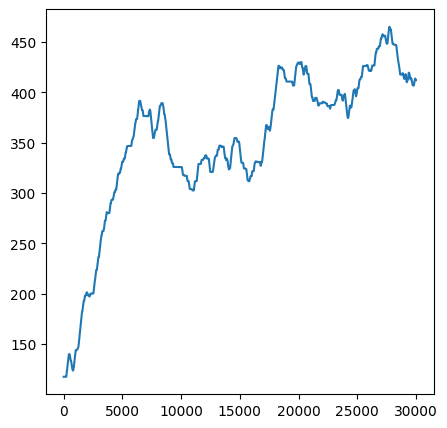

In [3]:
plt.figure(figsize=(5, 5))
plt.plot(player_coords[:,0])
plt.show()

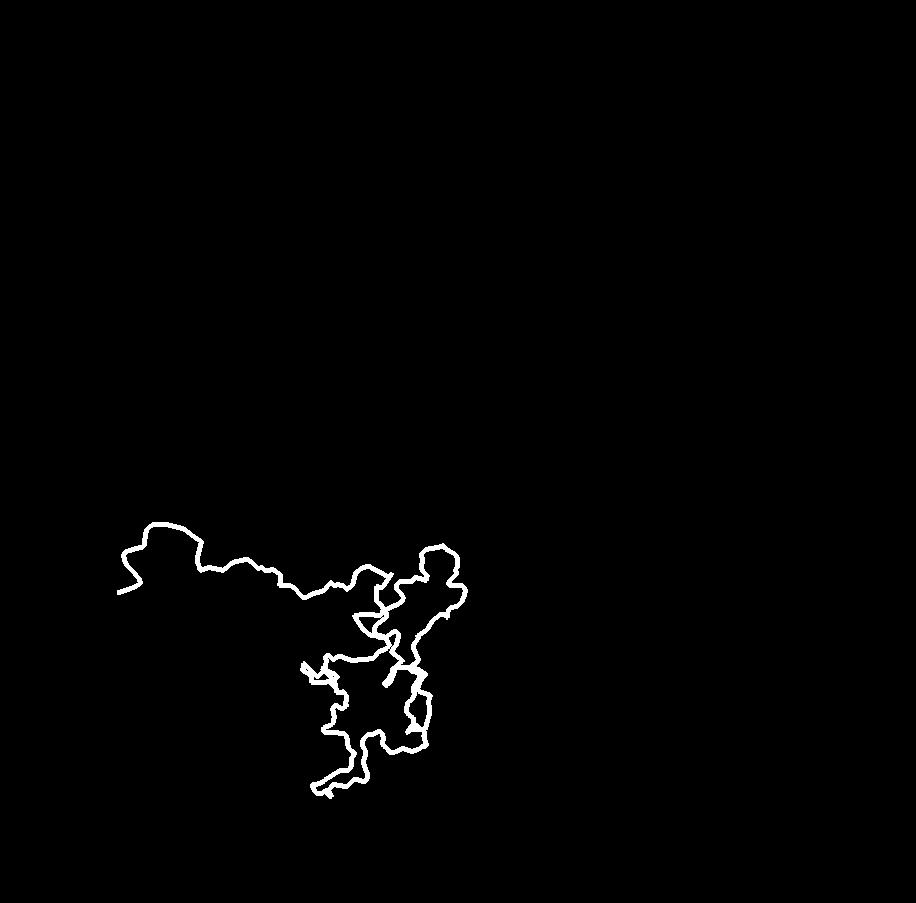

In [5]:
with Image.new(mode="1", size=(max_coord_x, max_coord_z)) as im:
    draw = ImageDraw.Draw(im)
    draw.line([tuple(p) for p in player_coords.astype(int)], fill=1, width=5)
    display.display(im)
    player_trajectory = np.array(im)

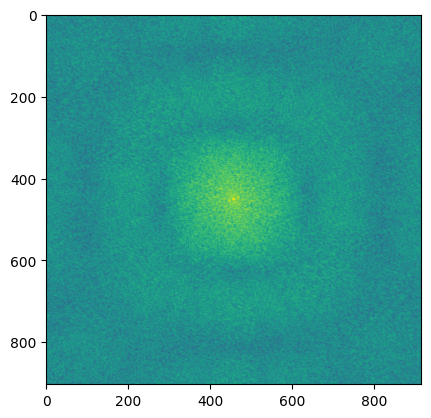

In [6]:
fft_transform = np.fft.fftshift(np.fft.fft2(player_trajectory))
fft_transform = np.log(abs(fft_transform))
# with Image.fromarray(fft_transform.astype(np.int8), mode="L") as im:
#     display.display(im)
plt.imshow(fft_transform)
